In [1]:
import sys
sys.version

'3.5.4 |Anaconda custom (64-bit)| (default, Nov  8 2017, 18:11:28) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [106]:
# load libraries
import numpy as np
import h5py
import gdal
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import rasterio
from skimage import exposure
import rasterstats as rs
import copy
%matplotlib inline

In [3]:
# user-defined values

mapped_stems_file = "data/output/mapped_stems_final.shp"

tree_polygons_file = 'data/output/polygons_checked_overlap.shp'

hs_file = "data/hyperspectral/NEON_D13_NIWO_DP3_450000_4432000_reflectance.h5"

site = "NIWO" # this is needed to navigate the h5 tree

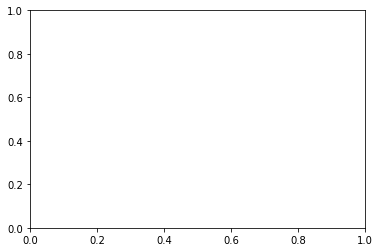

In [4]:
# User-defined functions. Many of these come from NEON tutorials: 

def aop_h5refl2array(refl_filename):
    """aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
           1. reflectance array (with the no data value and reflectance scale factor applied)
           2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
    --------
    NOTE: This function applies to the NEON hdf5 format implemented in 2016, and should be used for
    data acquired 2016 and after. Data in earlier NEON hdf5 format (collected prior to 2016) is 
    expected to be re-processed after the 2018 flight season. 
    --------
    Example Execution:
    --------
    sercRefl, sercRefl_metadata = h5refl2array('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5') """

    import h5py

    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]

    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflRaw = refl['Reflectance_Data'].value

    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    #metadata['interleave'] = reflData.attrs['Interleave']

    #Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata['data ignore value'] in reflRaw:
        print('% No Data: ',np.round(np.count_nonzero(reflClean==metadata['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata['data ignore value'])
        reflClean[nodata_ind]=np.nan 

    #Apply scale factor
    reflArray = reflClean/metadata['reflectance scale factor']

    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']

    #Extract bad band windows
    metadata['bad band window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad band window2'] = (refl.attrs['Band_Window_2_Nanometers'])

    #Extract projection information
    #metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)

    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value

    hdf5_file.close        

    return reflArray, metadata


def stack_rgb(reflArray,bands):
    # creates a numpy stack of red, green, blue bands
    # from https://www.neonscience.org/neon-hsi-aop-functions-tiles-py 
    import numpy as np

    red = reflArray[:,:,bands[0]-1]
    green = reflArray[:,:,bands[1]-1]
    blue = reflArray[:,:,bands[2]-1]

    stackedRGB = np.stack((red,green,blue),axis=2)

    return stackedRGB



def plot_aop_refl(band_array,refl_extent,colorlimit=(0,1),ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):

    '''plot_refl_data reads in and plots a single band or 3 stacked bands of a reflectance array
    --------
    Parameters
    --------
        band_array: array of reflectance values, created from aop_h5refl2array
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
                     use metadata['spatial extent'] from aop_h5refl2array function
        colorlimit: optional, range of values to plot (min,max). 
                    - helpful to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: optional; plot title (string)
        cmap_title: optional; colorbar title 
        colormap: optional (string, see https://matplotlib.org/examples/color/colormaps_reference.html) for list of colormaps
    --------
    Returns 
    --------
        plots flightline array of single band of reflectance data
    --------

    Examples:
    --------
    plot_aop_refl(sercb56,
              sercMetadata['spatial extent'],
              colorlimit=(0,0.3),
              title='SERC Band 56 Reflectance',
              cmap_title='Reflectance',
              colormap='Greys_r') '''

    import matplotlib.pyplot as plt

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect='auto'); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees
    

# plot RGB image using contrast stretching
def plot_aop_rgb(rgbArray,ext,ls_pct=5,plot_title=''):

    from skimage import exposure

    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

In [76]:
h5_data, h5_metadata = aop_h5refl2array(hs_file)
print('h5_data (scaled reflectance data) shape', h5_data.shape)

# read bad band windows 
bbw1 = h5_metadata['bad band window1']; 
bbw2 = h5_metadata['bad band window2']; 
print('Bad Band Window 1:',bbw1)
print('Bad Band Window 2:',bbw2)

(1000, 1000, 426)
Bad Band Window 1: [1340 1445]
Bad Band Window 2: [1790 1955]


## Mapped Stems and Polygons

In [6]:
# read mapped stems shapefile
mapped_stems = gpd.read_file(mapped_stems_file)
mapped_stems.head()

,indvdID,scntfcN,taxonID,geometry
0,NEON.PLA.D13.NIWO.00260,Abies lasiocarpa (Hook.) Nutt. var. lasiocarpa,ABLAL,POINT (450032.8731916947 4433597.509626328)
1,NEON.PLA.D13.NIWO.00262,Picea engelmannii Parry ex Engelm.,PIEN,POINT (450035.6774237959 4433606.070288112)
2,NEON.PLA.D13.NIWO.00463,Picea engelmannii Parry ex Engelm.,PIEN,POINT (450129.0238475716 4433080.988866569)
3,NEON.PLA.D13.NIWO.00477,Picea engelmannii Parry ex Engelm.,PIEN,POINT (450127.4621571384 4433086.713280249)
4,NEON.PLA.D13.NIWO.01023,Pinus contorta Douglas ex Loudon var. latifoli...,PICOL,POINT (453322.405271168 4432450.418917234)


In [7]:
# read tree polygons 
tree_polygons = gpd.read_file(tree_polygons_file)
tree_polygons.head()

,scntfcN,taxonID,indvdID,crownDm,height,geometry
0,Pinus contorta Douglas ex Loudon var. latifoli...,PICOL,NEON.PLA.D13.NIWO.01808,21.4,1.3,"POLYGON ((452249.12052449 4431767.89490231, 45..."
1,Pinus flexilis James,PIFL2,NEON.PLA.D13.NIWO.01625,10.0,12.8,"POLYGON ((451467.41209032 4432048.9069198, 451..."
2,Pinus contorta Douglas ex Loudon var. latifoli...,PICOL,NEON.PLA.D13.NIWO.01999,9.9,12.7,"POLYGON ((452313.3706157354 4432619.078871572,..."
3,Pinus flexilis James,PIFL2,NEON.PLA.D13.NIWO.01161,9.0,10.9,"POLYGON ((453723.3775669254 4433265.376067628,..."
4,Pinus flexilis James,PIFL2,NEON.PLA.D13.NIWO.01159,8.0,9.6,"POLYGON ((453717.26966523 4433266.17977435, 45..."


shapefile crs:  {'init': 'epsg:32613'}


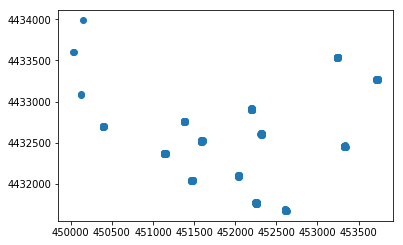

In [8]:
# print some information about the shapefile
print('shapefile crs: ', mapped_stems.crs) 

# quick plot of the stems 
mapped_stems.plot()

In [9]:
# list the column names of the data frame
mapped_stems.dtypes

# add a new column with the geographic extent of each entry
#mapped_stems.loc[:,'xMin'] = None

indvdID     object
scntfcN     object
taxonID     object
geometry    object
dtype: object

## Hyperspectral processing

Hyperspectral code from NEON: https://www.neonscience.org/neon-aop-hdf5-py 

In [10]:
# read hyperspectral imagery
f = h5py.File(hs_file,'r') 

In [11]:
def list_dataset(name,node):
    # lists the names of datasets in an hdf5 file
    if isinstance(node, h5py.Dataset):
        print(name)

#f.visititems(list_dataset)


def ls_dataset(name,node):
    # displays the name, shape, and type of datasets in hdf5 file
    if isinstance(node, h5py.Dataset):
        print(node)

#f.visititems(ls_dataset)

In [12]:
# extract the reflectance data 
refl = f['NIWO']['Reflectance']
# the refl_array is a h5py._hl.dataset.Dataset containing 426 stacked 
# numpy arrays, each for a spectral band. 
refl_array = refl['Reflectance_Data']
refl_shape = refl_array.shape
print(refl_array)
print(refl_shape)

<HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">
(1000, 1000, 426)


In [13]:
# extract the reflectance metadata
wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
print(wavelengths)
# print(wavelengths.value)

# Display min & max wavelengths
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

<HDF5 dataset "Wavelength": shape (426,), type "<f4">
min wavelength: 381.273 nm
max wavelength: 2509.728 nm


In [14]:
#Extract relevant metadata - (can probably delete this if using the NEON functions)

# Get the coordinate system map info
mapInfo = refl['Metadata']['Coordinate_System']['Map_Info']
print('Map Info:\n', mapInfo.value)

mapInfo_string = str(mapInfo.value) #convert to string
mapInfo_split = mapInfo_string.split(",") #split the strings using the separator "," 
print(mapInfo_split)

# CRS EPSG to set the CRS attribute of the current HS tile
crs_epsg = refl['Metadata']['Coordinate_System']['EPSG Code']
crs_epsg_string = 'epsg:'+ str(crs_epsg.value.decode("utf-8"))

#Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]),float(mapInfo_split[6])
print('Resolution:',res)

#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])
#Calculate the xMax and yMin values from the dimensions
#xMax = left corner + (# of columns * resolution)
xMax = xMin + (refl_shape[1]*res[0])
yMin = yMax - (refl_shape[0]*res[1]) 

# print('xMin:',xMin) ; print('xMax:',xMax) 
# print('yMin:',yMin) ; print('yMax:',yMax) 
ext = (xMin, xMax, yMin, yMax)
print('ext:',ext)

#Can also create a dictionary of extent:
extDict = {}
extDict['xMin'] = xMin
extDict['xMax'] = xMax
extDict['yMin'] = yMin
extDict['yMax'] = yMax
print('extDict:',extDict)

Map Info:
 b'UTM,  1.000,  1.000,       450000.00,       4433000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0'
["b'UTM", '  1.000', '  1.000', '       450000.00', '       4433000.0', '       1.0000000', '       1.0000000', '  13', '  North', '  WGS-84', '  units=Meters', " 0'"]
Resolution: (1.0, 1.0)
ext: (450000.0, 451000.0, 4432000.0, 4433000.0)
extDict: {'yMax': 4433000.0, 'xMin': 450000.0, 'yMin': 4432000.0, 'xMax': 451000.0}


Extract a single band, plot a histogram and the reflectance image

band type: <class 'numpy.ndarray'>
band shape: (1000, 1000)
Band 100 Reflectance:
 [[0.2699 0.2573 0.252  ... 0.362  0.3542 0.3268]
 [0.2358 0.2512 0.2347 ... 0.2944 0.3057 0.297 ]
 [0.2688 0.2798 0.2242 ... 0.3337 0.3359 0.3458]
 ...
 [0.0136 0.0092 0.0104 ... 0.1724 0.2021 0.2011]
 [0.027  0.0995 0.0338 ... 0.3009 0.2696 0.2316]
 [0.0448 0.0612 0.0373 ... 0.2479 0.2607 0.2205]]


Text(0,0.5,'Frequency')

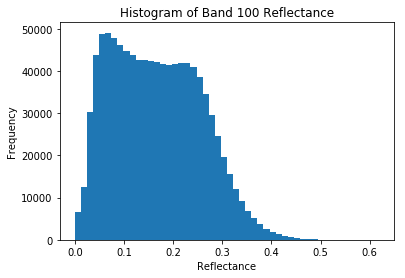

In [15]:
# extract a single band
band = 100

b = h5_data[:,:,int(band)].astype(float)

print('band type:',type(b))
print('band shape:',b.shape)
print('Band ' + str(band) + ' Reflectance:\n',b)

# plot a histogram of the pixel values
plt.hist(b.flatten(),bins = 50);
plt.title('Histogram of Band ' + str(band) + ' Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

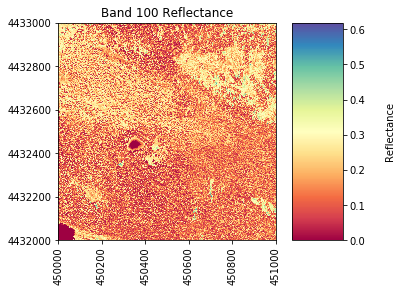

In [16]:
# plot the reflectance values with a colormap applied
plot_aop_refl(b,
              h5_metadata['spatial extent'],
              colorlimit=(np.amin(b),np.amax(b)),
              title='Band ' + str(band) + ' Reflectance',
              cmap_title='Reflectance',
              colormap='Spectral') 

Red Band 58 Center Wavelength = 666.74 nm
Green Band 34 Center Wavelength = 551.55 nm
Blue Band 19 Center Wavelength = 471.42 nm


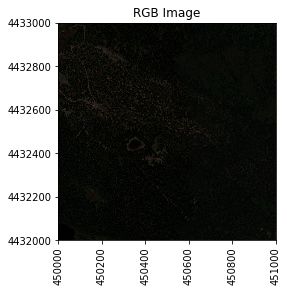

In [17]:
# RGB composite 

# define which bands to use to Red, Green, and Blue
rgb_bands = (58,34,19)
print('Red Band 58 Center Wavelength = %.2f' %(wavelengths[57]),'nm')
print('Green Band 34 Center Wavelength = %.2f' %(wavelengths[34]),'nm')
print('Blue Band 19 Center Wavelength = %.2f' %(wavelengths[18]),'nm')

# create RGB stack for current tile
rgb = stack_rgb(h5_data,rgb_bands)

# plot RGB composite
plot_aop_refl(rgb,
               h5_metadata['spatial extent'],
               title='RGB Image',
               cbar='off') 


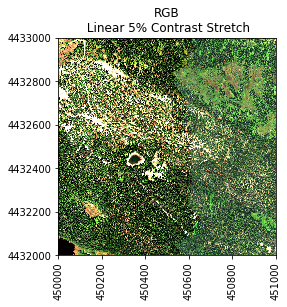

In [18]:
# plot RGB with 5% linear contrast stretch 
plot_aop_rgb(rgb,
             h5_metadata['spatial extent'],
             plot_title = 'RGB')

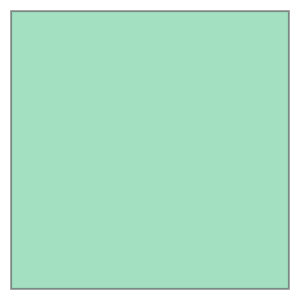

In [19]:
# filter the stems for those within the boundary of the current HS tile 

# create a polygon using the extent of the tile
easting_list = [extDict['xMin'], extDict['xMax'], extDict['xMax'], extDict['xMin'], extDict['xMin']]
northing_list = [extDict['yMin'], extDict['yMin'], extDict['yMax'], extDict['yMax'], extDict['yMin']]

tile_poly = shapely.geometry.Polygon(zip(easting_list, northing_list))
tile_boundary = gpd.GeoDataFrame(index=[0], crs={'init' : crs_epsg_string}, geometry=[tile_poly])

tile_poly

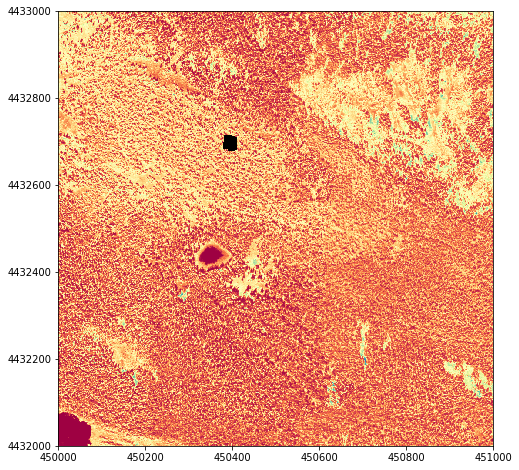

In [20]:
# determine which mapped stems are within the current HS tile 
stems_in_tile = mapped_stems[mapped_stems.geometry.within(tile_poly)]


# plot the mapped stems over the tile
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(b,
          extent=ext,
          cmap='Spectral')
stems_in_tile.plot(ax=ax,
                  marker='s',
                  markersize=45,
                  color='black')
plt.show()

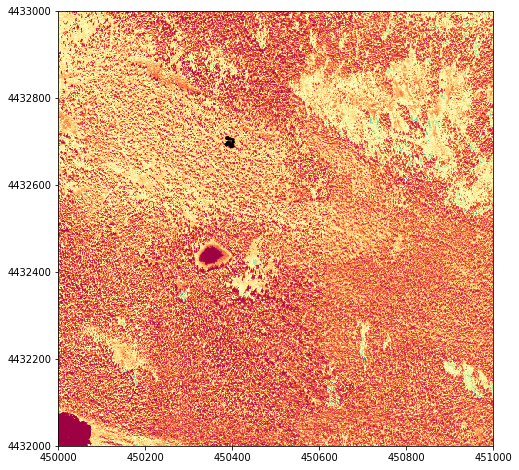

In [21]:
#determine which tree polygons are within the current tile 
trees_in_tile = tree_polygons[tree_polygons.geometry.within(tile_poly)]


# plot the mapped tree polygons over the tile
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(b,
          extent=ext,
          cmap='Spectral')
trees_in_tile.plot(ax=ax,
                   linewidth=2, edgecolor='black')
plt.show()

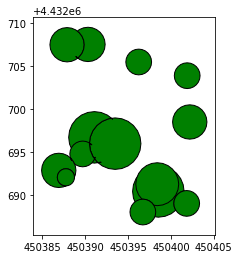

In [51]:
# plot the polygons in the current tile
trees_in_tile.plot(linewidth=1, color = 'green', edgecolor='black')

In [134]:
# To clip the hyperspectal data with each polygon, 
# it appears there are a few ways to go about doing this.
# One way is to write each band as a TIF file using rasterio 
# so the arrays become georeferenced.
# Then read each band and clip using the polygon, with the rs.zonal_stats function 


stems_in_tile.indvdID.iloc[0].split('.')[-1]




'01131'

In [138]:
# spectra for the tree point locations 


# create data frame to store extracted spectra 
# each row corresponds to a spectral band in the hyperspectral data
# each column corresponds to a tree stem in the current tile 
spectra = np.zeros((wavelengths.shape[0], stems_in_tile.shape[0]), dtype='float64')


# loop through polygons, grab the spectra from the HS stack
for i in range(0,stems_in_tile.shape[0]):

    # get the image coordinates of each tree location
    indX = int(np.round(stems_in_tile.geometry.x.iloc[i] - h5_metadata['spatial extent'][0]))
    indY = int(np.round(stems_in_tile.geometry.y.iloc[i] - h5_metadata['spatial extent'][2]))
    
    # extract the spectra 
    spectra[:,i] = h5_data[indX, indY,:]

    
    
# plot the spectra, with bad bands removed

# set the bad band windows to nan, along with the last 10 bands, which are also often noisy 
w = copy.copy(h5_metadata['wavelength']) #make a copy to deal with the mutable data type
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan #can also use bbw1[0] or bbw1[1] to avoid hard-coding in
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate

#define index corresponding to nan values:
nan_ind = np.argwhere(np.isnan(w))

# set the bad band values equal to NAN
spectra[nan_ind,:] = np.nan

# create a dataframe with wavelengths and each of the reflectance spectra for the trees
wavelengths_df = pd.DataFrame()
wavelengths_df['wavelengths'] = h5_metadata['wavelength']

spectra_df = pd.concat([wavelengths_df, pd.DataFrame(spectra)], axis = 1)

# melt the data frame to incorporate the species information for plotting by group
spectra_df

,wavelengths,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,381.273010,0.0661,0.0760,0.1380,0.0902,0.0875,0.0507,0.0647,0.0618,0.0703,0.0628,0.0735,0.0611,0.0759,0.0443
1,386.281097,0.0579,0.0543,0.1114,0.0529,0.0593,0.0459,0.0511,0.0483,0.0586,0.0566,0.0623,0.0466,0.0681,0.0410
2,391.289215,0.0372,0.0406,0.0881,0.0420,0.0478,0.0356,0.0392,0.0444,0.0450,0.0461,0.0443,0.0341,0.0510,0.0360
3,396.297302,0.0366,0.0377,0.0884,0.0452,0.0508,0.0356,0.0352,0.0376,0.0368,0.0435,0.0431,0.0365,0.0504,0.0296
4,401.305511,0.0296,0.0344,0.0809,0.0374,0.0421,0.0274,0.0297,0.0334,0.0348,0.0406,0.0387,0.0273,0.0434,0.0293
5,406.313599,0.0256,0.0308,0.0765,0.0347,0.0372,0.0245,0.0276,0.0326,0.0336,0.0360,0.0340,0.0280,0.0409,0.0244
6,411.321686,0.0299,0.0320,0.0774,0.0364,0.0413,0.0254,0.0295,0.0334,0.0352,0.0380,0.0356,0.0275,0.0416,0.0244
7,416.329895,0.0264,0.0300,0.0730,0.0347,0.0381,0.0234,0.0276,0.0313,0.0308,0.0331,0.0325,0.0246,0.0400,0.0237
8,421.338013,0.0263,0.0308,0.0722,0.0331,0.0375,0.0228,0.0264,0.0295,0.0322,0.0336,0.0311,0.0243,0.0387,0.0212
9,426.346100,0.0253,0.0303,0.0721,0.0323,0.0372,0.0233,0.0258,0.0299,0.0313,0.0318,0.0305,0.0236,0.0375,0.0206


[Text(0,0.5,'Reflectance'), Text(0.5,0,'Wavelength [nm]')]

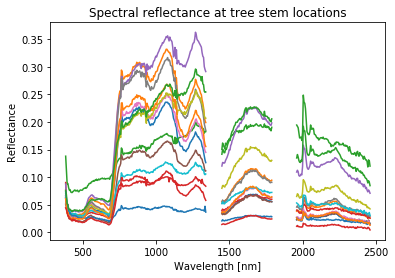

In [139]:
fig = spectra_df.plot(x='wavelengths', 
                      title = 'Spectral reflectance at tree stem locations',
                     legend=False)
fig.set(xlabel="Wavelength [nm]", ylabel=("Reflectance"))

Crop the imagery:
https://www.earthdatascience.org/workshops/gis-open-source-python/crop-raster-data-in-python/

https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/extract-data-from-raster/

In [23]:
# check the spatial ref of the polygons and the raster 
print('Coordinate Reference System of shapefile: ')
print(stems_in_tile.crs['init'])

print('Coordinate Reference System of h5 file: ')
print(h5_metadata['epsg'])


# for a single mapped stem
stem = stems_in_tile.iloc[0]

# for a single tree polygon
tree = trees_in_tile.iloc[0]

tree





# temp file module?
# try following the earth analytics tutorial to extract raster values using a shapefile 
# write each band to a .tif, then delete it after it's extracted. .... not efficient but it could work! 


# Extract zonal stats
tree_refl = rs.zonal_stats(tree,
                           b,
                            affine=sjer_chm_meta['transform'],
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")



Coordinate Reference System of shapefile: 
epsg:32613
Coordinate Reference System of h5 file: 
32613


NameError: name 'sjer_chm_meta' is not defined

In [ ]:
# found this script on GitHub to clip AOP h5 file but it doesn't run, 
# looks like some metadata tags have changed since 2016

https://github.com/lwasser/pythonWork/blob/master/AOP_subsetHSIData/subset_aop_h5_file.py 








#!/usr/bin/python

##
# \file subset_aop_h5_file.py
# \brief This script will subset an L1 AOP H5 spectral radiance file, given an input
#        shape-shape file defining the clipping boundary.
#        Usage:
#            python subset_aop_h5_file.py -i inputfile.h5 -c clip.shp -o output.h5
#        -i / --input  : Required input h5 file.
#        -c / --clip   : Required input shp file.
#        -o / --output : Optional output parameter.  If omitted, "Subset_" is prepended to the input filename.
#
# \author Josh Elliott jelliott@neoninc.org
# \date 20 Oct 2015
# \version 1.0
# \updated 27 April 2016, Leah A Wasser
# \modified calc of newMapTie point to use the data tie point and calculate via
# \ pixel "offset" rather than using the polygon extent
# Use: python subset_aop_h5_file.py --input NIS1_20140601_145336_atmcor.h5 --clip HarvardClipBox.shp --output newfile.h5

import os
from osgeo import ogr
from osgeo import osr
ogr.UseExceptions() # Throw exceptions so we can catch them properly.
import h5py as h5
import numpy as np
import argparse

##
# \class Subsetter
# \brief Subsetter class which will take an input h5 file, an shp file, and create a new
#        subsetted h5 file based on the input shp file.
#
class SubsetAOPh5:
    def __init__(self, h5File, shpFile, outputFile=''):
        self.rasterFile = h5File
        self.shapeFile = shpFile
        self.outputFile = outputFile
        if (len(outputFile) < 1):
            self.outputFile = os.path.join(os.path.dirname(h5File), 'Subset_' + os.path.basename(h5File))
        
        # Get polygon boundaries
        polygons, vectorSpatialRef = self.__GetPolygonsFromShapefile()
        
        # Open the file
        f = self.__OpenH5(self.rasterFile)
        
        # Get the coordinate system information
        rasterSpatialRef, mapInfo = self.__GetRasterSpatialRef(f)
        
        # Reproject the polygons to match the raster
        projectedPolygons = self.__ReprojectPolygons(polygons, vectorSpatialRef, rasterSpatialRef)
        
        # Get the map tie point and pixel size
        MapInfo = mapInfo.value[0].decode(encoding='utf_8').split(',')
        pixelSize = [float(i) for i in MapInfo[5:7]]
        pixelTiePoint = [float(i)-1.0 for i in MapInfo[1:3]] #Stored in 1-based pixel locations.  We want 0-based.
        mapTiePoint = [float(i) for i in MapInfo[3:5]]
        reflectance = f['Reflectance']
        # grab the dimensions of the matrix  to use in calculating the new tie
        # point  
        self.xyDims = reflectance.shape[1:3]
        
        # Check for rotation
        hasRotation = "rotation" in MapInfo[-1]
        if hasRotation:
            theta = np.float64(MapInfo[-1].split('=')[-1])
            projectedPolygons = self.__TransformPolygons(-theta, projectedPolygons.copy(), mapTiePoint)
            
        # Get the bounding box of the polygon.
        boundingBoxUTM = self.__GetBoundingBox(projectedPolygons)
                    
        # Get the pixel space bounding box.
        boundingBox = self.__GetPixelBoundingBox(boundingBoxUTM, pixelSize, pixelTiePoint, mapTiePoint)

        # [xmin, ymax] is the upper-left point of the raster.  This is the new map tie point.
        newMapTiePoint = [float('nan'),float('nan')]
        # calculate NEW x tie point using Original Data tie point as "0,0" reference
        newMapTiePoint[0] = mapTiePoint[0] + boundingBox[0] * pixelSize[0]
        # calculate NEW x tie point using Original Data tie point as "0,0" reference
        newMapTiePoint[1] = mapTiePoint[1] - boundingBox[2] * pixelSize[1]

        # Insert this into MapInfo string, which we will write to the new file.
        # newMapTiePoint = [str(boundingBox[0]), str(boundingBox[3])]
        if hasRotation:
            newMapTiePoint = self.__TransformPoint(theta, newMapTiePoint, mapTiePoint)

        # Create the new MapInfo string, with the new tie point.
        MapInfo[3:5] = [str(newMapTiePoint[0]), str(newMapTiePoint[1])]
        MapInfo = ','.join(MapInfo)

        
        # Determine which datasets to subset.
        rasters, notRasters = self.__GetDatasetKeys(f)
        
        # new file
        fsubset = h5.File(self.outputFile, "w")
        
        # copy all non-rasters into the new file, except "map info", do that separately.
        for notRaster in notRasters:
            if 'map info' not in notRaster:
                newdataset = fsubset.create_dataset(notRaster, f[notRaster].shape, data= f[notRaster])
                self.__CopyAttributes(f[notRaster], newdataset)
        subsetMap = fsubset.create_dataset('map info', mapInfo.shape, data=MapInfo)
        self.__CopyAttributes(mapInfo, subsetMap)
        
        # Subset each raster and add to the new file
        for raster in rasters:
            subset = f[raster][:,boundingBox[2]:boundingBox[3]+1,boundingBox[0]:boundingBox[1]+1]
            dset = fsubset.create_dataset(raster, subset.shape, data=subset, compression='gzip', compression_opts=8, chunks=True)
            self.__CopyAttributes(f[raster], dset)
            if (raster in 'Reflectance'):
                dset.attrs['Scale Factor'] = 10000.0
            
        # close the file
        fsubset.close()
        
    def __CopyAttributes(self, orig, copy):
        for att in orig.attrs:
            copy.attrs.create(att, data=orig.attrs[att])
        
    def __GetDatasetKeys(self, f):
        keys = f.keys()
        rasters = []
        notRasters = []
        for key in keys:
            dims = f[key].shape
            if len(dims) == 3:
                rasters.append(key)
            else:
                notRasters.append(key)
        return rasters, notRasters
        
    def __GetPixelBoundingBox(self, boundingBox, pixelSize, pixelTiePoint, mapTiePoint):
    
        xs = boundingBox[0:2]
        ys = boundingBox[2:4]
        newBoundingBox = np.zeros(shape=(4,), dtype=np.int64)
    
        newXs = []
        newYs = []
        for x in xs:
            delX = (x - float(mapTiePoint[0])) / pixelSize[0]
            newX  = pixelTiePoint[0] + delX
            newXs.append(newX)
        newBoundingBox[0:2] = [ int(round(x)) for x in newXs ] # round to integer pixel locations
        for y in ys:
            delY = (y - float(mapTiePoint[1])) / pixelSize[1]
            newY = pixelTiePoint[1] - delY
            newYs.append(newY)
        newBoundingBox[3] = int(round(newYs[0])) # reverse order
        newBoundingBox[2] = int(round(newYs[1]))
        
        # check the min and max values; added 4/27
        # open reflectance dataset to get x and y shape
        # reflectance = f['Reflectance']
        # grab the dimensions of the matrix  to use in calculating the new tie
        # point  
        # not sure how this is being stored here - ask greg. i need it to become 
        # a variable i think? 
        # xyDims = reflectance.shape[1:3]
        # check x min and max values, ensure they are within the index boundaries
        # of the original data. The clipping polygon extent could fall OUTSIDE of the
        # data extent.
        if newBoundingBox[0] < 0:
            newBoundingBox[0] = 0
        if newBoundingBox[1] > self.xyDims[0]:
            newBoundingBox[1] = self.xyDims[0]
            
        # check the min and max values 
        # check Y min and max values, ensure they are within the index boundaries
        if newBoundingBox[2] < 0:
            newBoundingBox[2] = 0
        if newBoundingBox[3] > self.xyDims[1]:
            newBoundingBox[3] = self.xyDims[1]
       
        # 
        
        return newBoundingBox
    
    def __GetBoundingBox(self, polygons):
        # Collect the x and y min/max and return [xmin, xmax, ymin, ymax]
        boundingBox = np.zeros(shape=(4,), dtype=np.float64)
        
        isFirstPoint = True
        
        for polygon in polygons:
            for point in polygon:
                X = point[0]
                Y = point[1]
                
                if isFirstPoint:
                    boundingBox[0] = X
                    boundingBox[1] = X
                    boundingBox[2] = Y
                    boundingBox[3] = Y
                    isFirstPoint = False
                else:
                    if X < boundingBox[0]:
                        boundingBox[0] = X
                    elif X > boundingBox[1]:
                        boundingBox[1] = X
                    if Y < boundingBox[2]:
                        boundingBox[2] = Y
                    elif Y > boundingBox[3]:
                        boundingBox[3] = Y
        
        return boundingBox
            
    def __GetPolygonsFromShapefile(self):
        # First, get the GDAL/OGR driver for reading shapefiles.
        driver = ogr.GetDriverByName('ESRI Shapefile')
        # Have the driver open the file.
        dataSource = driver.Open(self.shapeFile)
        # Get the layer
        layer = dataSource.GetLayer()
        
        # Get the points from the geometry
        polygons = []
        for feat in layer:
            geom = feat.GetGeometryRef()
            ring = geom.GetGeometryRef(0)
            
            points = ring.GetPointCount()
            ps = []
            for p in range(points):
                point = ring.GetPoint_2D(p)
                ps.append(point)
            polygons.append(ps)
            
        # Get the Spatial Reference object (i.e. the map projection info) from the Layer.
        spatialRef = layer.GetSpatialRef()
        
        return polygons, spatialRef
    
    def __OpenH5(self, h5File):
        return h5.File(h5File, 'r') # read only
    
    def __GetRasterSpatialRef(self, f):
        css = f['Coordinate_System_String']
        mapInfo = f['map info']
        rasterSpatialRef = osr.SpatialReference()
        rasterSpatialRef.ImportFromWkt(css[0].decode(encoding='utf_8'))
        return rasterSpatialRef, mapInfo
        
    def __ReprojectPolygons(self, polygons, sourceSpatialRef, targetSpatialRef):
        transform = osr.CoordinateTransformation(sourceSpatialRef, targetSpatialRef)
        outputPolygons = []
        for polygon in polygons:
            outputPolygon = []
            for point in polygon:
                wkt = "POINT (" + str(point[0]) + " " + str(point[1]) + ")"
                newPoint = ogr.CreateGeometryFromWkt(wkt)
                newPoint.Transform(transform)
                outputPolygon.append([newPoint.GetX(), newPoint.GetY()])
            outputPolygons.append(outputPolygon)
        return outputPolygons
    
    def __TransformPolygons(self, theta, polygons, tiePoint):
        outputPolygons = []
        for polygon in polygons:
            outputPolygon = []
            for point in polygon:
                transformedPoint = self.__TransformPoint(theta, point, tiePoint)
                outputPolygon.append(transformedPoint)
            outputPolygons.append(outputPolygon)
        return outputPolygons
    
    def __TransformPoint(self, theta, point, tiePoint):
        radians = np.radians(theta)
        r00 = np.cos(radians)
        r01 = -np.sin(radians)
        r10 = -r01
        r11 = r00
        x = tiePoint[0]
        y = tiePoint[1]
        T1 = np.matrix([
                       [1.0, 0.0, x],
                       [0.0, 1.0, y],
                       [0.0, 0.0, 1.0]
                       ], 
                      dtype=np.float64)
        T2 = np.matrix([
                       [1.0, 0.0, -x],
                       [0.0, 1.0, -y],
                       [0.0, 0.0, 1.0]
                       ], 
                      dtype=np.float64)
        R = np.matrix([
                       [r00, r01, 0.0],
                       [r10, r11, 0.0],
                       [0.0, 0.0, 1.0]
                       ], 
                      dtype=np.float64)
        p = np.matrix([[point[0]],[point[1]], [1.0]], dtype=np.float64)
        transformedPoint = T1 * R * T2 * p
        return [transformedPoint[0,0], transformedPoint[1,0]]

In [ ]:
# Can't get this to run..... 
SubsetAOPh5(hs_file, tree_polygons_file)
    
